Smartmeter Data Science Challenge
=================================

This challenge is designed to test basic electrical engineering skills together
with data science techniques.

It involves a slimmed-down problem of non-intrusive load monitoring (NILM) for
smartmeter data measured in our office.

The data
--------

The data is a table of smartmeter measurements over 0.2 sec time intervals.  The
measured quantities (from a single AC phase) are:

  * `I_rms`: RMS current (in A)

  * `U_rms`: RMS voltage (in V)

  * `S`: apparent power (in VA)

  * `Q`: reactive power (in VA)

  * `P`: active power (in W)

  * `harmonic_I_NN`: the `NN`th harmonic of current, for 3rd, 5th and 7th
    harmonics of the AC frequency

The AC frequency of this data is 50 Hz, and the rating voltage is 230 V.

The challenge
-------------

Based on the provided data, answer the following questions:

  * Identify when in the time series devices are being turned on and
    off

  * How many distinct devices can be observed?  Can you map individual
    on/off events to the device?

      - you do not need to identify the _actual_ device, but rather
        to classify the events based on features in the dataset

  * Based on the different feature values associated with different
    devices, can you say anything about the kinds of device they are?
    (Give clear reasons for your answers.)

We recommend (but do not strictly require) that you implement your solution as
a Jupyter Notebook using Python, as this is the language our team uses most in
production.

Some requirements:

  * Try to write clean and clear code that a colleague would find a
    pleasure to maintain and modify (use code documentation as you
    see fit to aid in this)

  * Please document your work and ideas in a way that helps us clearly
    understand the reasons for your approach and the thinking behind
    any insights you obtain

Feel free to ask us whatever questions you like, just as if you were a colleague
working remotely.

* How would it change your approach if you would know that the switching time between on and off of a device is only a few milliseconds and that then power level would be stable?


* git (priv. )repository: https://github.com/cohitai/frequenz

In [758]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import numpy as np
from scipy import signal
%matplotlib inline

In [759]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [725]:
path = '/home/itai/Downloads/meter_data.csv'

In [726]:
#global dataframe
df = pd.read_csv(path)

In [727]:
#adjusting timestamps
df['timestamp'] = df['timestamp'].apply(lambda x: np.timedelta64(pd.Timestamp(x) -pd.Timestamp(df['timestamp'].iloc[0]),'ms').astype(np.int32))

In [728]:
#index to timestamp dictionary for later
IND2TIME = df["timestamp"].to_dict()

In [729]:
df.head(5)

,timestamp,I_rms,U_rms,S,Q,P,harmonic_I_03,harmonic_I_05,harmonic_I_07
0,0,0.026616,238.914564,6.358997,4.107624,-1.103088,1.693918,2.364160,2.239170
1,189,0.022169,238.994721,5.298291,3.421000,-0.804425,2.711630,2.855956,1.912822
2,392,0.020819,239.176934,4.979447,3.722391,-0.704212,0.687889,3.624636,2.490151
3,595,0.026826,239.269831,6.418585,4.067994,-1.271494,4.530055,1.087715,3.392836
4,798,0.031124,239.261189,7.446851,3.810160,-1.343031,0.065944,2.000889,2.086636


In [730]:
df.tail(5)

,timestamp,I_rms,U_rms,S,Q,P,harmonic_I_03,harmonic_I_05,harmonic_I_07
9645,8382072,0.170232,236.780165,40.307558,3.855475,-1.749976,3.337991,5.010886,1.250956
9646,8382261,0.173348,236.808769,41.050440,3.568219,-1.480689,0.675882,5.329158,3.578383
9647,8382472,0.158800,236.919575,37.622733,4.083456,-1.179706,3.487976,5.090195,2.085005
9648,8382661,0.165998,237.034279,39.347210,3.960099,-1.486027,3.928940,4.666955,3.509041
9649,8382864,0.165162,237.209797,39.178052,4.239156,-1.663138,3.253428,6.072912,1.836846


# Split the data into subintervals according to when the active power p switches its sign. 

In [731]:
def fetch_segmentation():
    
    """auxilary function to fetch segments according to the active power from df. """
    #convert to numpy
    P_np = np.array(df['P'])
    #apply filter through switches
    res_filter =[x for x in range(0,9620) if (P_np[x-1]<0 and P_np[x]>10) or (P_np[x]>10 and P_np[x+1]<0)]
    #return tupled list of intervals
    return  [(res_filter[i],res_filter[i+1]) for i in range(0,len(res_filter),2)]

In [732]:
tup_list = fetch_segmentation()

In [733]:
def difference(dataset, interval=1):
    """interval-lag auxiliary
        :parameters: 
                    dataset (DataFrame)
                    intervel (int)
        :returns: 
                    DataFrame of (intervel)-Lag."""
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff,columns=["derivative"])


def smoothing(dg,window):
    """moving average auxiliary
    :parameters: 
                dg: dataframe
                window: integer
    :returns moving average for dg with size window. """     
    rolling = dg.rolling(window=window)
    return rolling.mean()

# Plot derivatives graph against the original graph; add markers for extremum. 

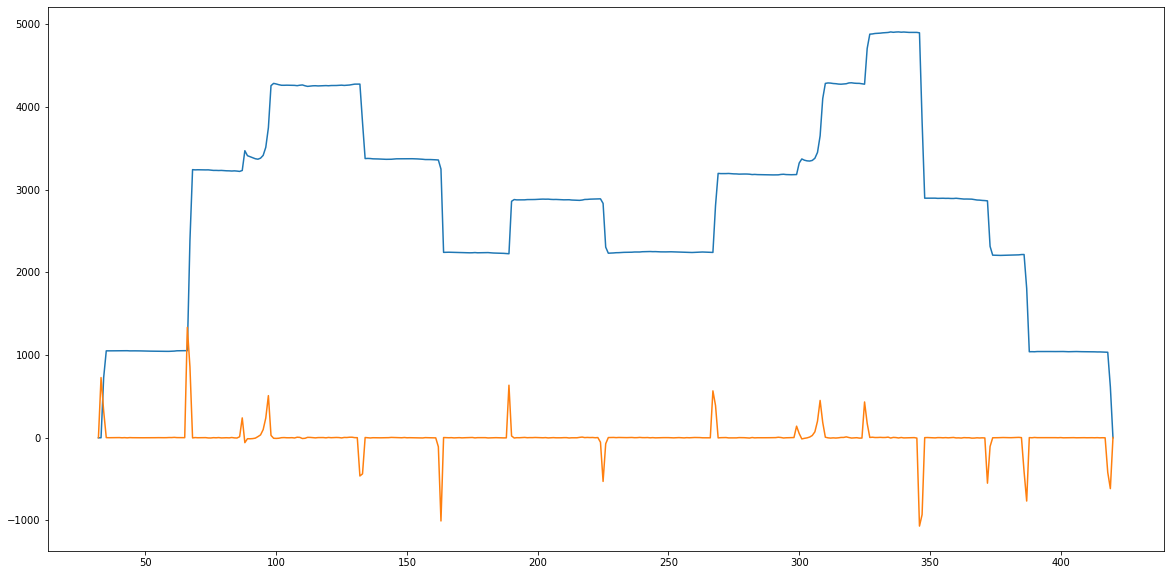

In [734]:
#interval (a,b):
(a,b) = tup_list[0][0]-2,tup_list[0][1]+2

#test 
plt.plot(df['P'][a:b])
plt.plot(difference(df['P'])[a:b])

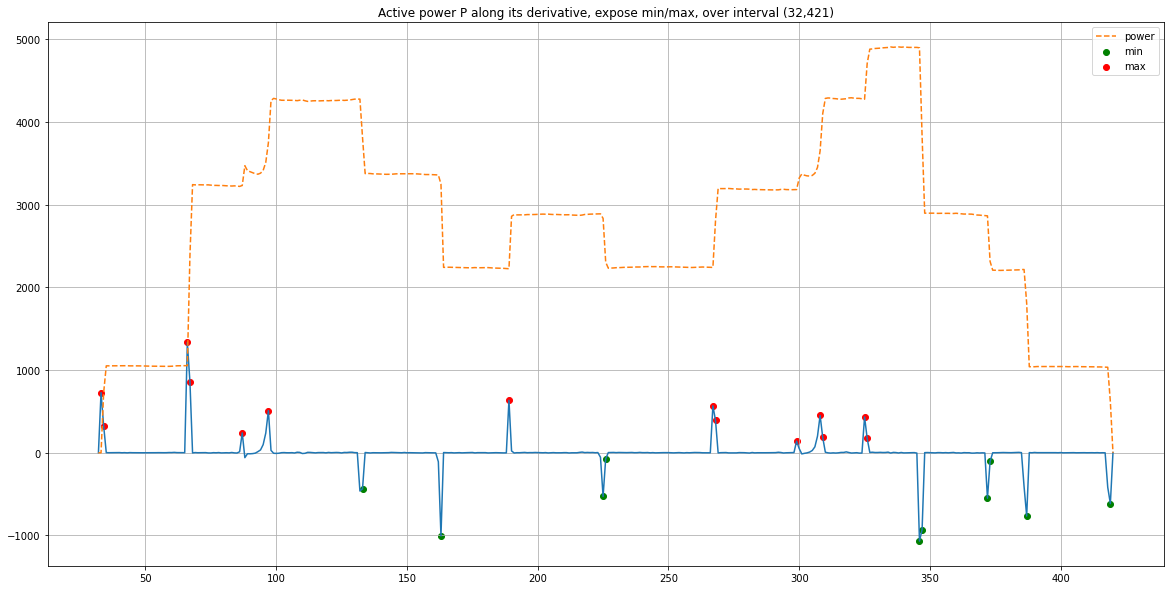

In [735]:
#test
#compute derivative; show extremum. 
diff = difference(df['P'])

# refining parameter
k = 50

#min/max
diff['min'] = diff.loc[( -k > diff["derivative"]) & (diff["derivative"].shift(-1)-k > diff["derivative"])]
diff['max'] = diff.loc[(diff["derivative"].shift(-1) < diff["derivative"]-k) & (diff["derivative"] > k) ]["derivative"]

# plot results
plt.scatter(diff[a:b].index, diff['min'][a:b], c='g',label='min')
plt.scatter(diff[a:b].index, diff['max'][a:b], c='r',label='max')
plt.plot(diff['derivative'][a:b])
plt.plot(df['P'][a:b],'--',label='power')
plt.grid(True)
plt.legend()
plt.title("Active power P along its derivative, expose min/max, over interval ({0},{1})".format(a,b))
plt.show()

# We'll fix the data as follows: 

Connecting adjuncts min/max points by adding these values respectively.

In [736]:
def connect_adjuncts(diff):
    
    """procedure to modify the diff (DataFrame), to connect all adjunct max/min points"""
    
    #extracting, prepering values
    df_ons,df_offs = diff['max'],diff['min']
    df_ons.dropna(inplace = True)
    df_offs.dropna(inplace = True)
    df_ons = df_ons.reset_index()
    df_offs = df_offs.reset_index()
    adjunct_ind_on = df_ons.loc[df_ons.shift(-1)["index"]==df_ons["index"]+1]["index"].index.tolist()
    adjunct_ind_off = df_offs.loc[df_offs.shift(-1)["index"]==df_offs["index"]+1]["index"].index.tolist()
    
    #create a new DataFrame for the added max/min
    don_t = pd.DataFrame(columns=['index',"max"])
    for i in adjunct_ind_on:
        new_row = (df_ons.loc[i]["index"], df_ons.loc[i]['max'] + df_ons.loc[i+1]['max'])
        don_t = don_t.append({'index': new_row[0],'max':new_row[1]},ignore_index=True)
    
    don_t = don_t.astype({"index": int})
    
    doff_t = pd.DataFrame(columns=['index',"min"])
    for i in adjunct_ind_off:
        new_row = (df_offs.loc[i]["index"], df_offs.loc[i]['min'] + df_offs.loc[i+1]['min'])
        doff_t = doff_t.append({'index': new_row[0],'min':new_row[1]},ignore_index=True)
    
    doff_t = doff_t.astype({"index": int})
    
    df_ons_new = df_ons.loc[list(set(df_ons.index)-set(adjunct_ind_on + [x+1 for x in adjunct_ind_on]))]
    df_ons_new = df_ons_new.append(don_t).set_index("index").sort_index()
    
    df_offs_new = df_offs.loc[list(set(df_offs.index)-set(adjunct_ind_off + [x+1 for x in adjunct_ind_off]))]
    df_offs_new = df_offs_new.append(doff_t).set_index("index").sort_index()
    
    #reset index to match diff.index
    index = pd.RangeIndex(start=0, stop=diff.shape[0])
    df_offs_new = df_offs_new.reindex(index)
    df_ons_new = df_ons_new.reindex(index)
    
    return pd.concat([df_ons_new, df_offs_new],axis=1)

In [737]:
#plot auxiliary.
def plot_interval(num,tup_list=tup_list, eta = 3, add_harmonic = False, modified = True):
    """:paramters: num - interval number
                   tuplist - list of tuples
                   eta - annotation parameter
        booleans:  add_harmonic - False (default) to omit harmonic plot 
                   modified - True (default) to modify derivative to sum together nearby extremum"""
    #extract interval 
    a,b = tup_list[num][0]-1,tup_list[num][1]+2
    #compute derivative according to the boolean "modified": 
    if modified: 
        d = connect_adjuncts(diff)
        title_predix_str = "MODIFIED:"
    else:
        d = diff
        title_predix_str = ""
    #scatter plot max,min
    plt.scatter(d[a:b].index, d['max'][a:b], c='r',label='max')
    plt.scatter(d[a:b].index, d['min'][a:b], c='g',label='min')
    #plot derivative, active power
    plt.plot(diff['derivative'][a:b],label='derivative')
    plt.plot(df['P'][a:b],'--',label='power')
    #harmonic plot 
    if add_harmonic:
        plt.plot(df['harmonic_I_03'][a:b],'--',label='harmonic_I_03')
    #add deco.    
    plt.grid(True)
    plt.legend()
    plt.title("{2} Active power P along its derivative, expose min/max, over interval ({0},{1})".format(a,b,title_predix_str))

    # add annotations
    x_max,y_max = d['max'][a:b].dropna().index.tolist(), d['max'][a:b].dropna().tolist()
    x_min,y_min = d['min'][a:b].dropna().index.tolist(), d['min'][a:b].dropna().tolist()
    
    for i in range(len(x_max)):
        plt.annotate(np.rint(y_max[i]), (x_max[i]+eta, y_max[i]+eta),fontsize=12)
    for i in range(len(x_min)):
        plt.annotate(np.rint(y_min[i]), (x_min[i]-eta, y_min[i]-eta),fontsize=12)

        
    plt.show()


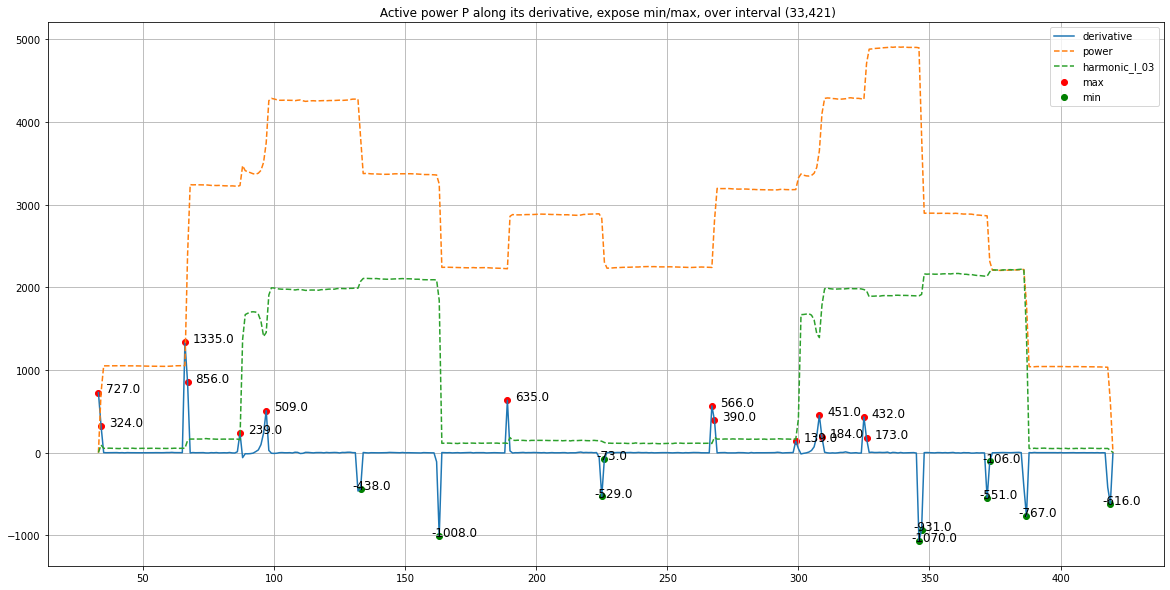

In [738]:
plot_interval(0,tup_list=tup_list,add_harmonic=True,modified= False)

* Assumption: every device which was turned on during an intervel, is eventually switched off as well. 

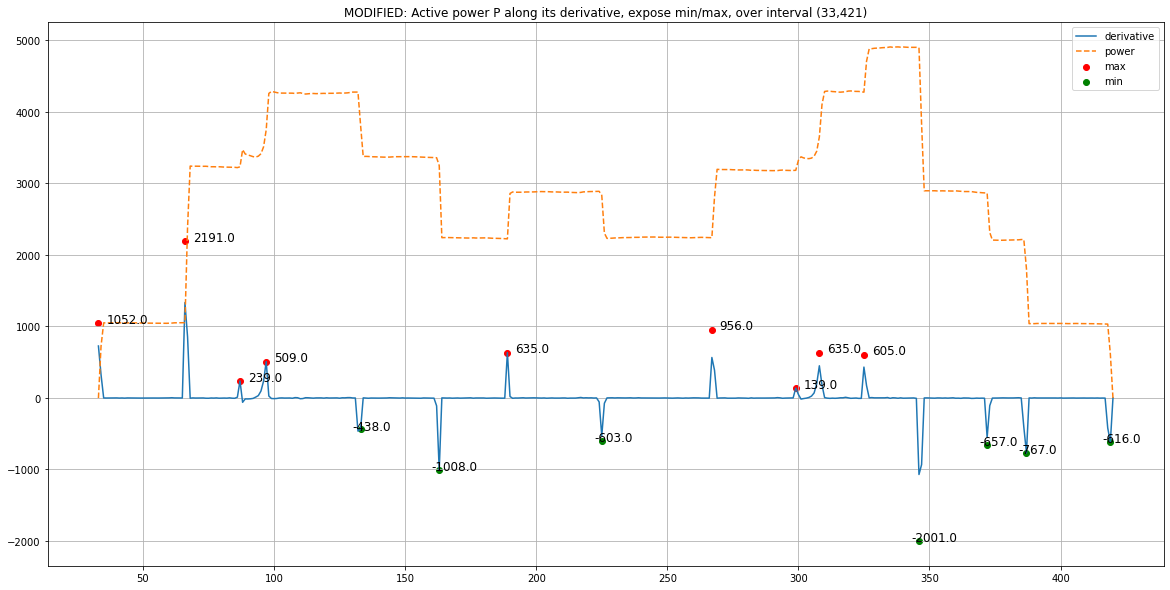

In [740]:
plot_interval(0,tup_list=tup_list)

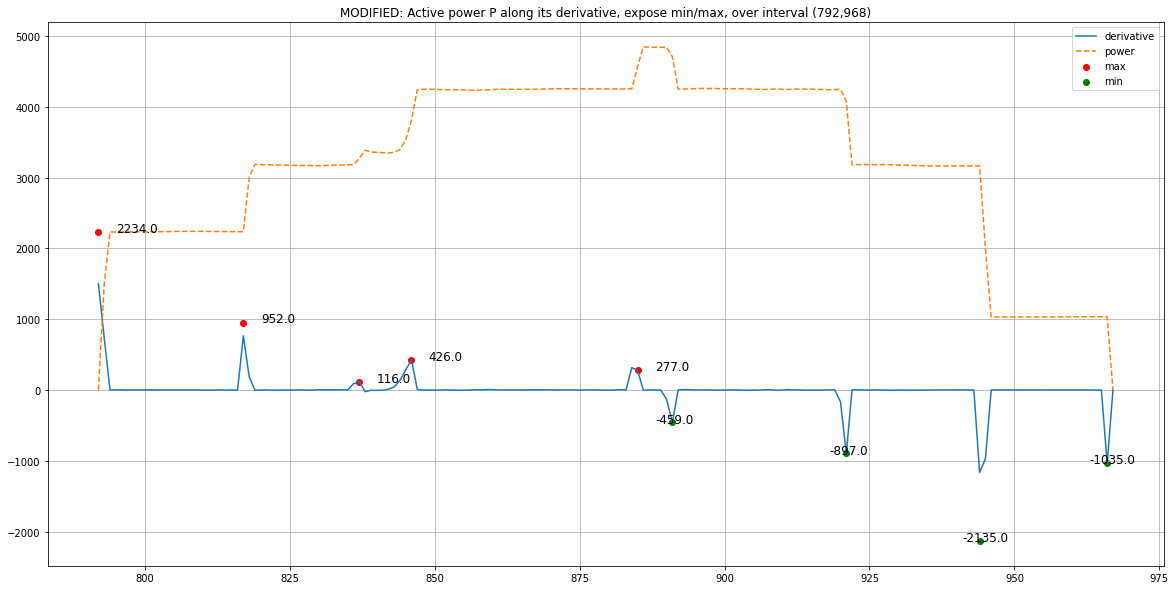

In [741]:
plot_interval(3,tup_list=tup_list)

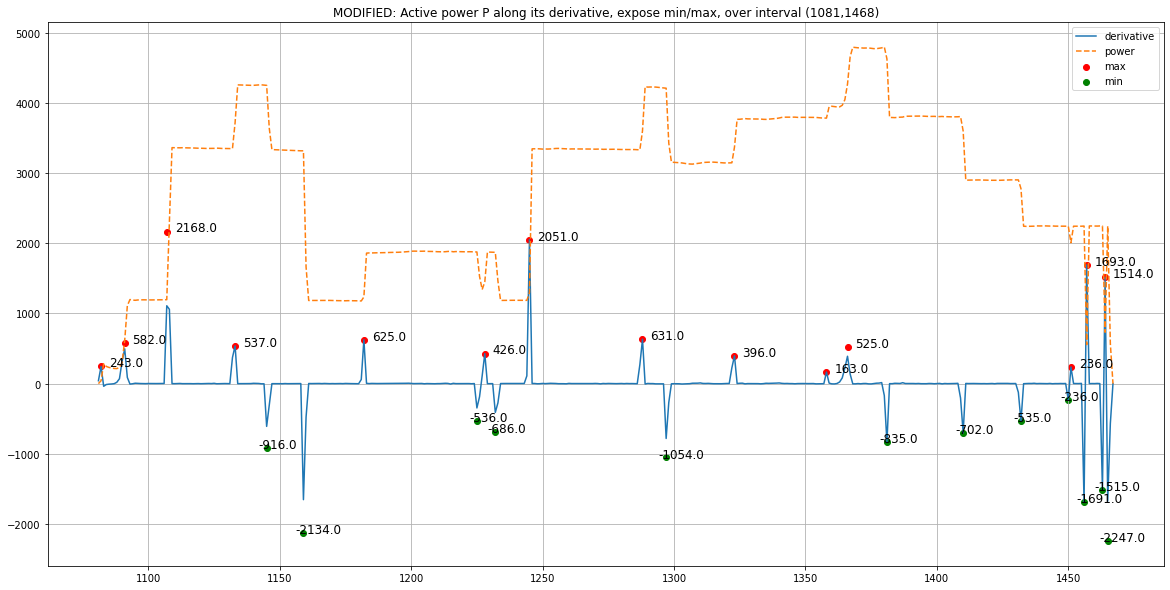

In [742]:
plot_interval(4,tup_list=tup_list)

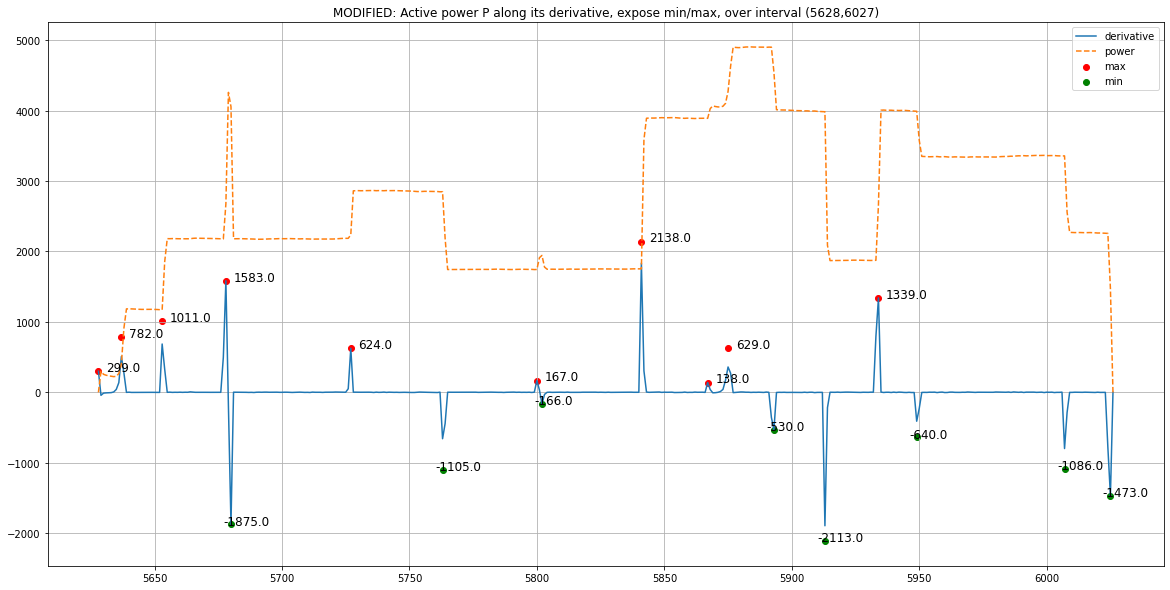

In [743]:
plot_interval(15,tup_list=tup_list)

# We create a simple matching algorithm between on/off events, to allow clustering them.

In [744]:
def GaussianKernel(v1, v2, sigma):
    """we add Gaussian kernel for the interval, putting more weights to nearby events
    :paramaters: v1,v2 vectors
                 sigma standard deviation.
    :returns: distance (int) """
    return np.exp(-np.linalg.norm(v1-v2)**2/(2.*sigma**2))


def matching_prediction(num,threshold=300):
    """we match switch ons to switch offs by computing euclidean distance with a gaussian kernel.
    :parameters: num (int) 
                threshold (int) for minimal consideration regarding distances.
    :returns pred a dictionary """
    
    #extract interval 
    a,b = tup_list[num][0]-1,tup_list[num][1]+2
    d = connect_adjuncts(diff)
    
    #standard deviation for the Gaussian kernel for the interval (b,a)
    sigma = (b-a)/6
    
    #initiate prediction dictionary
    pred = {}
    
    #connect adjuncts extremums
    d = connect_adjuncts(diff)
    
    #extract extremum information
    x_max,y_max = d['max'][a:b].dropna().index.tolist(), d['max'][a:b].dropna().tolist()
    x_min,y_min = d['min'][a:b].dropna().index.tolist(), d['min'][a:b].dropna().tolist()
    
    l_max=list(zip(x_max,y_max))
    l_min=list(zip(x_min,y_min))
    
    #initiate distance matrix with np.inf
    mat_dist = np.matrix(np.ones((len(x_max),len(x_min))) * np.inf)
    
    # loop over all maximum values
    for i,max_tup in enumerate(l_max):
        
        # exclude past minimum points since a switch on should precede a switch off.
        l_min_nominees = list(filter(lambda x: x[0]>max_tup[0] , l_min))
        
        # loop over all minimum values
        for j,min_tup in enumerate(l_min):
            if min_tup in l_min_nominees:
                # compute distance with Gaussian kernel
                mat_dist[i,j] = np.abs(max_tup[1]-np.abs(min_tup[1]))*(1-GaussianKernel(max_tup[0],min_tup[0],sigma)) 
    
    #we make the backword predictions by removing a cross i,j from the matrix corresponds to the minimal value. 
    while len(l_max) >=1:
        
        #Bug fixed: exception handling when multiple extremums occurs 
        try:
            n_i,n_j = map(int,np.where(mat_dist == mat_dist.min()))
        
        except TypeError:
            n_i,n_j = map(int,np.where(mat_dist == mat_dist.min())[1])
            
        
        if np.abs(l_max[n_i][1]-np.abs(l_min[n_j][1])) <= threshold: 
            pred[l_max[n_i]] = l_min[n_j]
        l_max.pop(n_i)
        l_min.pop(n_j)
        mat_dist = np.delete(mat_dist, n_i, 0)
        mat_dist = np.delete(mat_dist, n_j, 1)
        
        # stopping condition
        if len(l_min)*len(l_max) == 0:
            break

    return pred 
              
    

In [745]:
matching_prediction(3)

{(885, 276.52646606906274): (891, -459.4611099081367),
 (817, 952.2029828170994): (921, -896.732154768169),
 (792, 2233.544288876901): (944, -2135.173477173598)}

In [746]:
matching_prediction(4)

{(1228, 426.21382363742987): (1232, -686.2143028317332),
 (1133, 537.2059875688283): (1225, -536.2981318717243),
 (1457, 1692.9929047482356): (1463, -1514.921214278413),
 (1366, 525.2982308436694): (1432, -535.3558280930924),
 (1082, 243.35567731742145): (1450, -236.49179152511056),
 (1107, 2167.802915339847): (1159, -2134.4812492924425),
 (1182, 624.8117158279135): (1410, -701.5817618135848)}

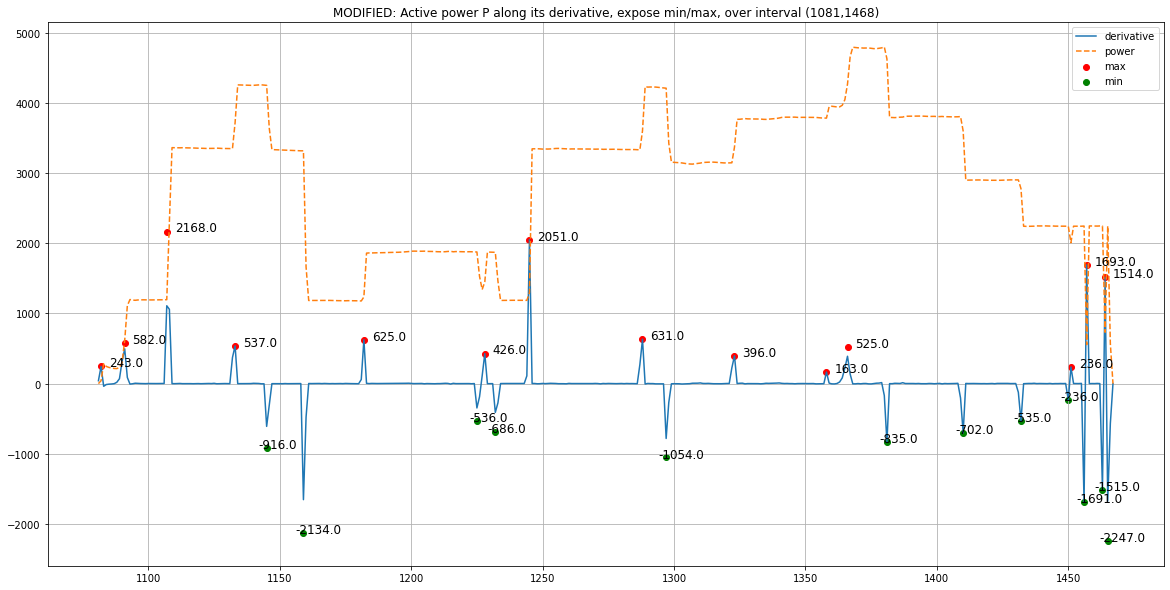

In [747]:
plot_interval(4)

In [748]:
matching_prediction(8)

{(3038, 2199.8588684067245): (3042, -2200.348944116726),
 (3025, 2078.922856239906): (3027, -2084.352478263332),
 (2848, 1017.1695695727644): (3005, -1009.9007364169711),
 (2990, 531.6847993554857): (3062, -502.44542058276727),
 (2931, 554.9343841748864): (2979, -476.47892138950283),
 (2834, 679.1275128372772): (2874, -485.4114451737869),
 (2820, 1025.158263448323): (2887, -927.5975888314429),
 (2918, 2105.2234592927366): (2959, -1892.15737911689)}

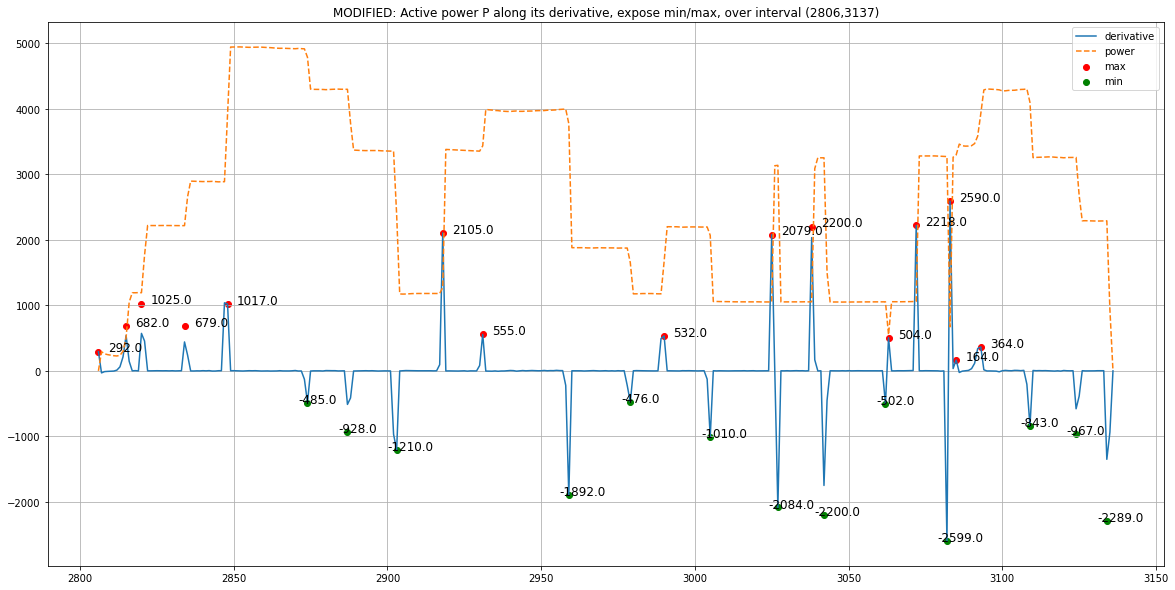

In [749]:
plot_interval(8)

## Collecting predicted events into dataframe

In [750]:
def create_events_dataframe(matching_func):
    
    """procedure to collect all events from matching_prediction's.
    :recieves: matching function. 
    :returns: ts pd.DataFrame() """

    column_names = ["start", "end","length","derivative_on", "derivative_off","difference"]

    ts = pd.DataFrame(columns = column_names)

    #loop over all tuples
    for i in range (len(tup_list)):
        temp_dict = matching_func(i)
        
        #loop over all events
        for item in temp_dict.items():
            #extract values 
            event_start = IND2TIME[item[0][0]]/1000
            event_end = IND2TIME[item[1][0]]/1000
            derivative_on =item[0][1]
            derivative_off =item[1][1]
            event_length =event_end - event_start 
            difference = np.abs(derivative_on+derivative_off)
            
            #make a row to append 
            to_append = [event_start, event_end, event_length, derivative_on, derivative_off, difference]
            a_series = pd.Series(to_append, index = ts.columns)
            ts = ts.append(a_series, ignore_index=True)
    return ts
        
    

In [751]:
ts = create_events_dataframe(matching_prediction)

In [752]:
ts.head()

,start,end,length,derivative_on,derivative_off,difference
0,37.789,44.996,7.207,634.823044,-602.646101,32.176943
1,64.993,83.797,18.804,605.303368,-616.486166,11.182797
2,61.604,74.396,12.792,634.774485,-657.206280,22.431795
3,19.395,26.601,7.206,508.820298,-437.769230,71.051068
4,6.593,32.591,25.998,1051.707372,-1007.876890,43.830482


In [753]:
ts.tail()

,start,end,length,derivative_on,derivative_off,difference
123,7998.361,8044.959,46.598,2163.911448,-2215.984955,52.073507
124,8315.064,8327.064,12.000,622.208603,-604.453782,17.754821
125,8266.832,8374.665,107.833,2170.571448,-2150.265653,20.305795
126,8301.870,8345.472,43.602,1459.835706,-1409.953698,49.882008
127,8268.635,8322.670,54.035,612.445388,-887.419144,274.973756


In [754]:
#check
a = ts.shape[0]
b = d['max'].dropna().shape[0]
c = a/b
print("{0} monitored events out of {1} recorded events, which are {2}% of all events.".format(a,b,c))

128 monitored events out of 241 recorded events, which are 0.5311203319502075% of all events.


In [755]:
from sklearn.cluster import KMeans

class Km:
    
    """class to implement Kmeans on previous collected data"""
    
    def __init__(self,k,ts,num_random_states):
        self.ts=ts
        self.k=k
        self.iterates = num_random_states
        self.threshold = num_random_states-2
        
    def apply_kmeans(self):
        X = np.array(ts['derivative_on']).reshape(self.ts.shape[0],1)
        Y = np.array(ts['length']).reshape(self.ts.shape[0],1)
        X_tag = np.hstack((Y,X))
        result_list=[]
        result_dict = {}
        for j in range(self.iterates):
            kmeans = KMeans(n_clusters=self.k, random_state=j).fit(X_tag)
            labels = kmeans.labels_
            result_dict = {i:np.where(labels ==i)[0].tolist() for i in range(self.k)}
            result_list.append(result_dict)
        return result_list
    
    @staticmethod
    def _find_cluster(cluster_dict,k):
        
        """function recieve clustering dictionary, and segment number k.
       returns the cluster for segment k as a list.
       
       :parameters 
               cluster_dict, dictionary
               k, int 
       :returns list. """
    
        d_bool = {j: k in cluster_dict[j] for j in cluster_dict.keys()}
        return cluster_dict[list(filter(d_bool.get, d_bool))[0]]
    
    def sum_results(self, cluster_dict ):
        
        """function creates square matrix (universe x universe) to summarize the occurences of segments appearing in
        the same cluster by kmeans (over the average energy and time length). """
        
        
        mat = np.zeros((self.ts.shape[0],self.ts.shape[0]))
        for seg_r in range(self.ts.shape[0]):
            for universe in range(len(cluster_dict)):
                for term in self._find_cluster(cluster_dict[universe],seg_r):
                    mat[seg_r,term]+=1
                    
        return mat - len(cluster_dict)*np.identity(mat.shape[0])
                               
    def find_cluster(self,mat,i):
        bool_arr = mat[i] > self.threshold
        return np.where(bool_arr)[0]
                              

In [756]:
#run KMeans, we choose k = 10 (ad hoc). 
km = Km(ts=ts,k=10,num_random_states=10)
li = km.apply_kmeans()

In [757]:
from IPython.display import display

#order clusters by the derivative's means.
l = [ts.loc[li[0][i]] for i in range(10)]
l.sort(key = lambda x: x["derivative_on"].mean())

#display results
for cluster in l:
    print("mean derivative_on for this cluster is:", cluster["derivative_on"].mean())
    display(cluster)
    

mean derivative_on for this cluster is: 194.74454712905552


,start,end,length,derivative_on,derivative_off,difference
12,810.981,812.192,1.211,276.526466,-459.461110,182.934644
19,1537.751,1611.344,73.593,243.355677,-236.491792,6.863886
55,4473.320,4478.320,5.000,194.008706,-307.840151,113.831445
73,5168.924,5214.130,45.206,173.096554,-372.776682,199.680128
81,5868.533,5868.947,0.414,166.787272,-165.739618,1.047653
88,6195.588,6195.989,0.401,193.323176,-135.568441,57.754735
103,6934.561,6934.764,0.203,116.113980,-208.702619,92.588639


mean derivative_on for this cluster is: 427.36768883052605


,start,end,length,derivative_on,derivative_off,difference
9,741.584,753.388,11.804,464.778554,-378.544730,86.233824
15,1566.955,1567.751,0.796,426.213824,-686.214303,260.000479
23,1765.224,1766.036,0.812,442.768999,-626.873151,184.104152
26,1756.237,1764.634,8.397,432.458136,-492.705618,60.247482
35,2318.002,2353.407,35.405,368.056255,-313.490754,54.565500
52,4110.790,4176.584,65.794,359.237533,-389.549500,30.311966
64,4821.970,4828.181,6.211,408.163202,-588.210342,180.047140
78,5556.171,5580.984,24.813,374.243285,-335.832959,38.410326
79,5512.951,5524.559,11.608,478.617048,-766.183576,287.566528
91,6174.966,6245.793,70.827,474.274920,-487.950363,13.675443


mean derivative_on for this cluster is: 544.8948713251035


,start,end,length,derivative_on,derivative_off,difference
3,19.395,26.601,7.206,508.820298,-437.769230,71.051068
16,1547.945,1566.353,18.408,537.205988,-536.298132,0.907856
18,1594.553,1607.747,13.194,525.298231,-535.355828,10.057597
24,1709.425,1715.830,6.405,580.170823,-561.776277,18.394546
25,1724.626,1731.435,6.809,515.492811,-563.426464,47.933653
36,2287.199,2307.197,19.998,524.378921,-359.404097,164.974824
38,3349.274,3350.873,1.599,583.161639,-604.215685,21.054046
44,3990.975,4005.379,14.404,531.684799,-502.445421,29.239379
45,3979.169,3988.783,9.614,554.934384,-476.478921,78.455463
57,4482.324,4508.912,26.588,588.918886,-545.372599,43.546287


mean derivative_on for this cluster is: 656.2657874138777


,start,end,length,derivative_on,derivative_off,difference
0,37.789,44.996,7.207,634.823044,-602.646101,32.176943
1,64.993,83.797,18.804,605.303368,-616.486166,11.182797
2,61.604,74.396,12.792,634.774485,-657.206280,22.431795
7,744.589,774.987,30.398,621.279683,-651.058668,29.778985
21,1557.753,1603.347,45.594,624.811716,-701.581762,76.770046
29,2273.198,2347.811,74.613,607.554711,-605.661597,1.893114
30,2315.007,2317.001,1.994,776.758979,-1043.146967,266.387989
31,2290.203,2310.209,20.006,650.479752,-633.780935,16.698817
37,3337.875,3378.673,40.798,613.234017,-613.240778,0.006761
46,3959.773,3967.782,8.009,679.127513,-485.411445,193.716068


mean derivative_on for this cluster is: 935.910610233736


,start,end,length,derivative_on,derivative_off,difference
5,53.392,77.397,24.005,956.308871,-766.875161,189.433710
8,735.786,768.985,33.199,976.545808,-1019.555307,43.009499
13,797.383,818.179,20.796,952.202983,-896.732155,55.470828
39,3376.676,3381.074,4.398,903.315071,-920.733316,17.418245
51,4103.586,4119.791,16.205,932.026926,-878.040109,53.986817
66,4790.372,4832.169,41.797,926.797579,-1050.166522,123.368943
76,5535.156,5536.957,1.801,925.637039,-1152.999776,227.362737
109,7132.293,7147.494,15.201,911.989188,-876.661677,35.327510
119,8009.159,8039.757,30.598,938.372027,-932.984814,5.387213


mean derivative_on for this cluster is: 1034.6666716030466


,start,end,length,derivative_on,derivative_off,difference
4,6.593,32.591,25.998,1051.707372,-1007.876890,43.830482
22,1777.832,1780.832,3.000,1101.545308,-1096.766280,4.779029
27,1692.431,1728.428,35.997,1047.831885,-1010.241062,37.590823
43,3962.571,3993.968,31.397,1017.169570,-1009.900736,7.268833
47,3956.979,3970.374,13.395,1025.158263,-927.597589,97.560675
56,4494.522,4503.515,8.993,985.972554,-923.682722,62.289832
58,4464.315,4490.716,26.401,1024.760004,-978.464354,46.295650
86,5839.133,5861.146,22.013,1010.832177,-1105.024370,94.192192
96,6185.783,6212.776,26.993,992.682272,-780.629037,212.053235
114,7531.069,7586.268,55.199,1113.870636,-1137.330466,23.459829


mean derivative_on for this cluster is: 1258.6307435280169


,start,end,length,derivative_on,derivative_off,difference
32,2328.606,2338.607,10.001,1351.523463,-1289.171602,62.351861
50,4131.791,4134.984,3.193,1243.943942,-1084.228895,159.715047
54,4090.588,4172.788,82.200,1194.528179,-1427.094481,232.566302
87,5895.345,5913.545,18.200,1339.425620,-1472.562081,133.136461
93,6239.795,6249.996,10.201,1243.617573,-1131.667282,111.950291
100,6490.857,6501.060,10.203,1267.681899,-979.786097,287.895801
107,7075.694,7120.286,44.592,1196.038237,-1153.426510,42.611727
115,7521.055,7582.077,61.022,1232.287036,-1197.301939,34.985097


mean derivative_on for this cluster is: 1572.3556290162717


,start,end,length,derivative_on,derivative_off,difference
17,1612.756,1613.969,1.213,1692.992905,-1514.921214,178.071690
33,2276.803,2284.211,7.408,1483.249487,-1662.777601,179.528114
82,5844.135,5844.534,0.399,1583.397883,-1875.412651,292.014768
90,6184.781,6236.178,51.397,1642.302164,-1640.487932,1.814233
126,8301.870,8345.472,43.602,1459.835706,-1409.953698,49.882008


mean derivative_on for this cluster is: 2012.814421609838


,start,end,length,derivative_on,derivative_off,difference
10,749.384,780.992,31.608,1987.441661,-2226.984567,239.542906
11,784.379,789.193,4.814,2084.128122,-2208.985618,124.857496
28,2340.801,2342.211,1.410,1995.787445,-1986.576307,9.211139
34,2300.202,2325.007,24.805,1979.571337,-2026.486881,46.915544
42,3997.970,3998.370,0.400,2078.922856,-2084.352478,5.429622
72,5198.931,5209.719,10.788,1864.197324,-2075.435214,211.237890
98,6508.448,6530.848,22.400,2046.377228,-2079.387310,33.010082
102,6910.557,6910.951,0.394,2039.192791,-2047.554575,8.361783
116,7506.262,7558.070,51.808,2039.711030,-1912.015579,127.695451


mean derivative_on for this cluster is: 2168.4419986012585


,start,end,length,derivative_on,derivative_off,difference
6,13.200,69.195,55.995,2190.555183,-2001.223438,189.331745
14,792.387,822.782,30.395,2233.544289,-2135.173477,98.370812
20,1542.752,1553.151,10.399,2167.802915,-2134.481249,33.321666
40,3344.671,3359.881,15.210,2150.385598,-2159.716428,9.330830
41,4000.578,4001.372,0.794,2199.858868,-2200.348944,0.490076
48,3976.583,3984.779,8.196,2105.223459,-1892.157379,213.066080
59,4520.513,4539.931,19.418,2189.684047,-2263.554690,73.870643
60,4468.519,4512.713,44.194,2125.310110,-2173.615415,48.305305
63,4793.778,4851.369,57.591,2117.978328,-2102.212254,15.766074
69,5158.730,5245.531,86.801,2283.985792,-2277.903960,6.081833
